# Geo Parameters
_author: Ajay Shyam Pasam_

## Using Geo Information in Your Python Function

Users can utilize the Geo proxy object in their Python function to calculate parameter values for their simulations. To get started, the user needs to import the Geo Proxy object into their environment. Let's assume they import it as G:
```
from epymorph.geo.abstract import proxy as G
```

With the imported Proxy object, users can define their Geo parameters. When running the parameter function, the data will be based on the Geo specifications they are using for their simulation.

Note: If users are working with an internal Geo constructed by the epymorph team, they need to be aware of what a Geo consists of and how the data will be structured. This information will be available in the official documentation.


## Break Down of the Beta Function using the Humidity information from the `PEI` Geo

### Example: Influenza
Influenza is a respiratory disease that spreads through respiratory droplets when an infected person coughs, sneezes, or talks. The virus can survive on surfaces and in the air.

High Humidity: In regions with high humidity, respiratory droplets produced by an infected person tend to settle quickly due to increased droplet size. This reduces the likelihood of others inhaling infectious particles, resulting in a lower beta value and lower transmission rates.

Low Humidity: In regions with low humidity, smaller respiratory droplets may remain suspended in the air for longer periods, increasing the chances of others inhaling the virus. This could lead to a higher beta value and higher transmission rates.

This function takes two parameters, t (time) and n (node), to determine the beta value for a specific time and location in a simulation.


```
 geo_humidity = G['humidity']
 current_humidity = geo_humidity[t][n]
```

Here, we retrieve the humidity information from the Geo and extract the relevant data based on t and n.
```
 humidity_factor = (max(0.003404, min(current_humidity, 0.02008)) - 0.003404) / (0.02008 - 0.003404)
```

To calculate the humidity_factor based on the current_humidity value, we clamp the current_humidity value within the range [0.003404, 0.02008], subtract the lower bound (0.003404), and divide by the range (0.02008 - 0.003404). The purpose of this step is to normalize the humidity value to a factor between 0 and 1.

```
    beta *= 1 + humidity_factor
```
Finally, we adjust the beta value by multiplying it by 1 + humidity_factor. This adjustment takes into account the humidity factor, reducing the beta value when humidity is higher and increasing it when humidity is lower.



## Existing use of Beta Function 

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

from epymorph.context import SimContext
from epymorph.data import geo_library, ipm_library, mm_library

from epymorph.initializer import  single_location
from epymorph.simulation import Output,Simulation
from epymorph.util import stridesum

sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['sparsemod'](),
    mvm_builder=mm_library['pei']())

def calculate_beta(t,_):
    if 0 <= t < 15:
        return 0.7
    elif 15 <= t < 30:
        return 0.2
    elif 30 <= t < 55:
        return 0.4
    elif 55 <= t < 75:
        return 0.1
    elif 75 <= t < 125:
        return 0.15
    elif 125 <= t < 135:
        return 1.2
    elif 135 <= t < 225:
        return 0.1
    else:
        return 1.5

param = {
    'move_control': 1,
    'theta': 0.1,
    'omega': [0.55,0.05],
    'delta': [0.333, 0.5, 0.166,0.142,0.125],
    'gamma': [0.166, 0.333, 0.25],
    'rho': [0.4, 0.175, 0.015, 0.2, 0.6],
    'beta': calculate_beta,
}

def init(ctx: SimContext):
    return single_location(ctx, location=0, seed_size=10_000)

out1 = sim.run(
    param = param,
    start_date=date(2015, 1, 1),
    duration_days=365,
    initializer=init,
    rng=np.random.default_rng(1)
)

def plot_subplots(out1, out2,label1, label2, figsize=(12, 6),pop1 = 0,pop2 = 0):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    
    x_axis1 = [t.tausum for t in out1.ctx.clock.ticks]
    ax1.set_title(f"{label1}")
    ax1.set_xlabel('days')
    ax1.set_ylabel('persons (log scale)')
    ax1.set_yscale('log')
    
    compartments1 = [f"c{n}" for n in range(out1.ctx.compartments)]
    for i, event in enumerate(compartments1):
        y_axis = out1.prevalence[:, pop1, i]
        ax1.plot(x_axis1, y_axis, label=event)
    if out1.ctx.compartments <= 12:
        ax1.legend()

    x_axis2 = [t.tausum for t in out2.ctx.clock.ticks]
    ax2.set_title(f"{label2}")
    ax2.set_xlabel('days')
    ax2.set_ylabel('persons (log scale)')
    ax2.set_yscale('log')
    
    compartments2 = [f"c{n}" for n in range(out2.ctx.compartments)]
    for i, event in enumerate(compartments2):
        y_axis = out2.prevalence[:, pop2, i]
        ax2.plot(x_axis2, y_axis, label=event)
    if out2.ctx.compartments <= 12:
        ax2.legend()
    
    fig.tight_layout()
    
    plt.show()

def event_y_axis(out: Output, event_idx: int) -> np.ndarray:
    """Utility function for graphing incidence time-series."""
    taus_per_day = len(out.ctx.clock.taus)
    y_values = np.zeros((out.ctx.nodes, out.ctx.clock.num_days))
    for pop_idx in range(out.ctx.nodes):
        events_by_tau = out.incidence[:, pop_idx, event_idx]
        y_values[pop_idx] = stridesum(events_by_tau, taus_per_day)
    return y_values.T


## Demo of Beta Function Using Geo Information

<string>:4: RuntimeWarning: overflow encountered in exp


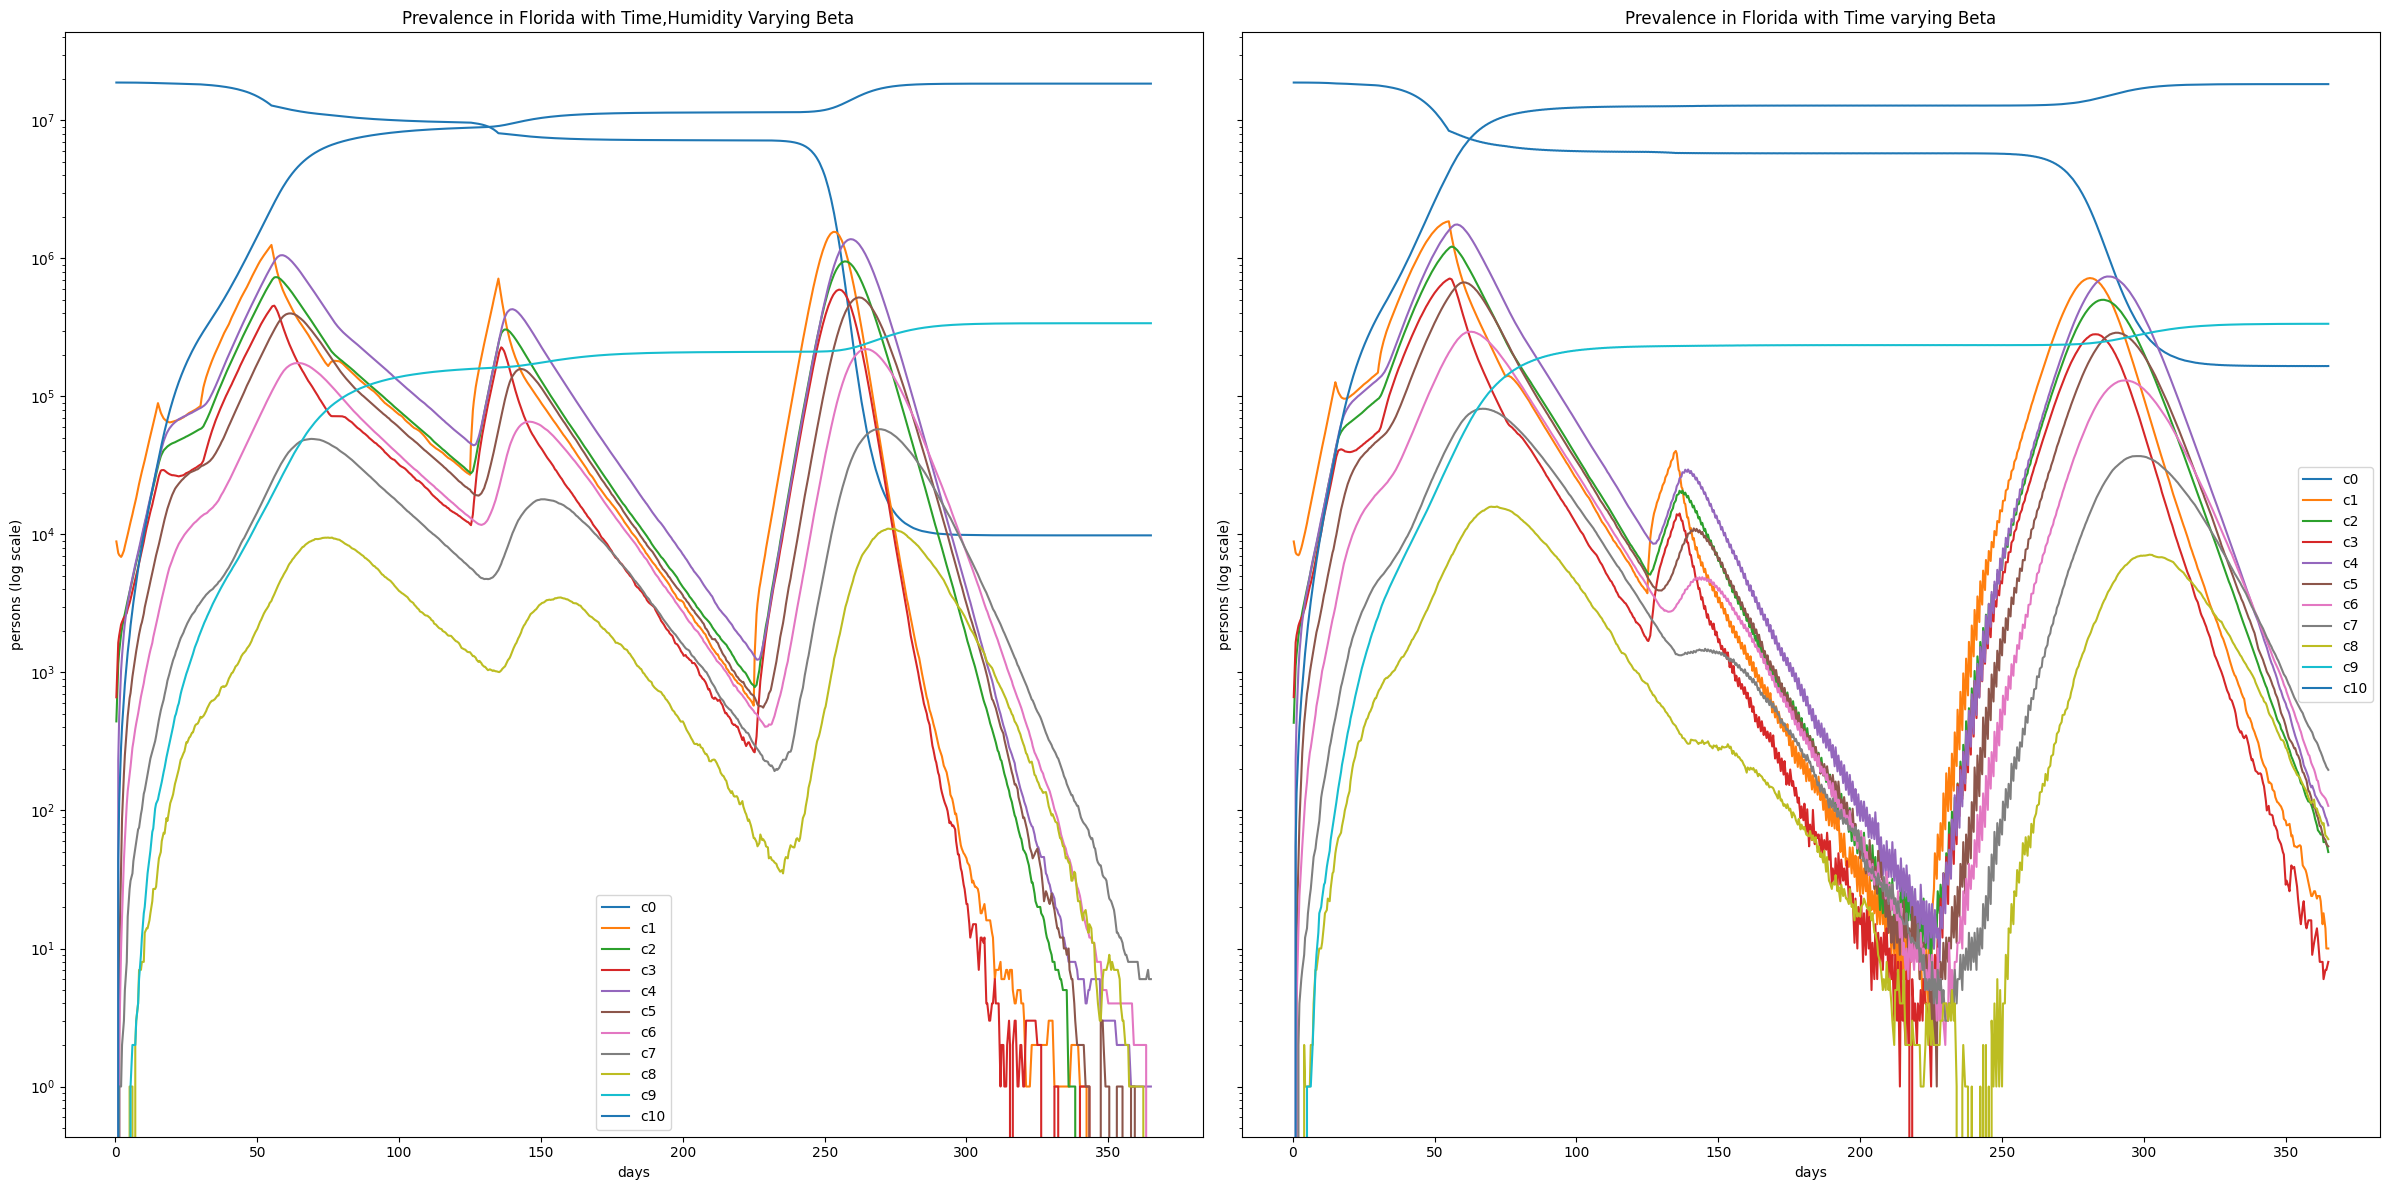

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


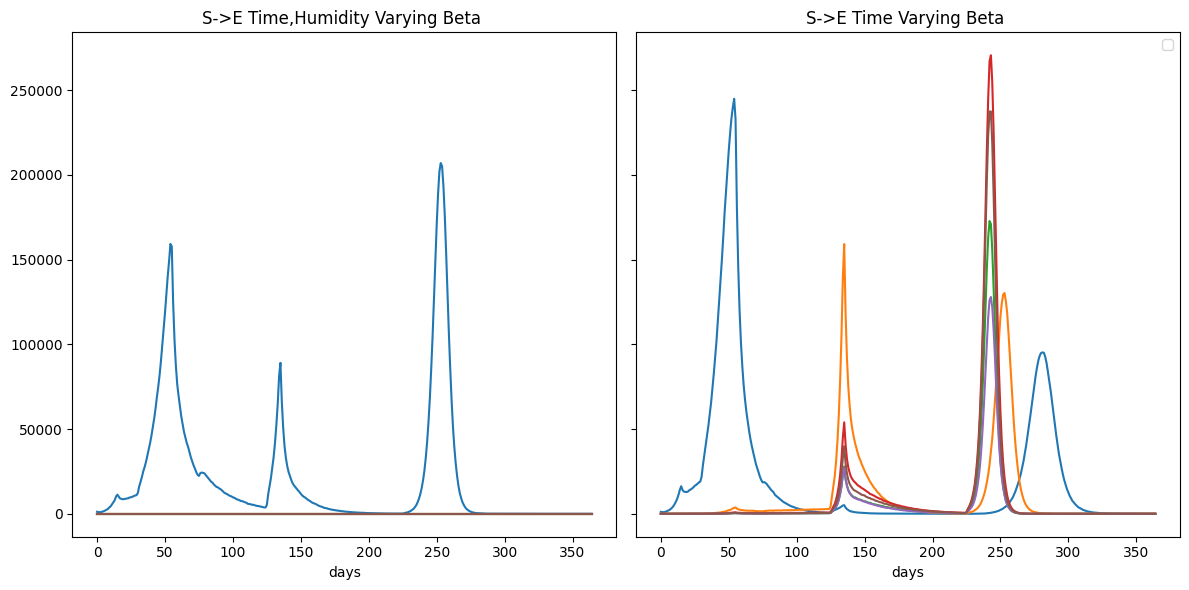

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


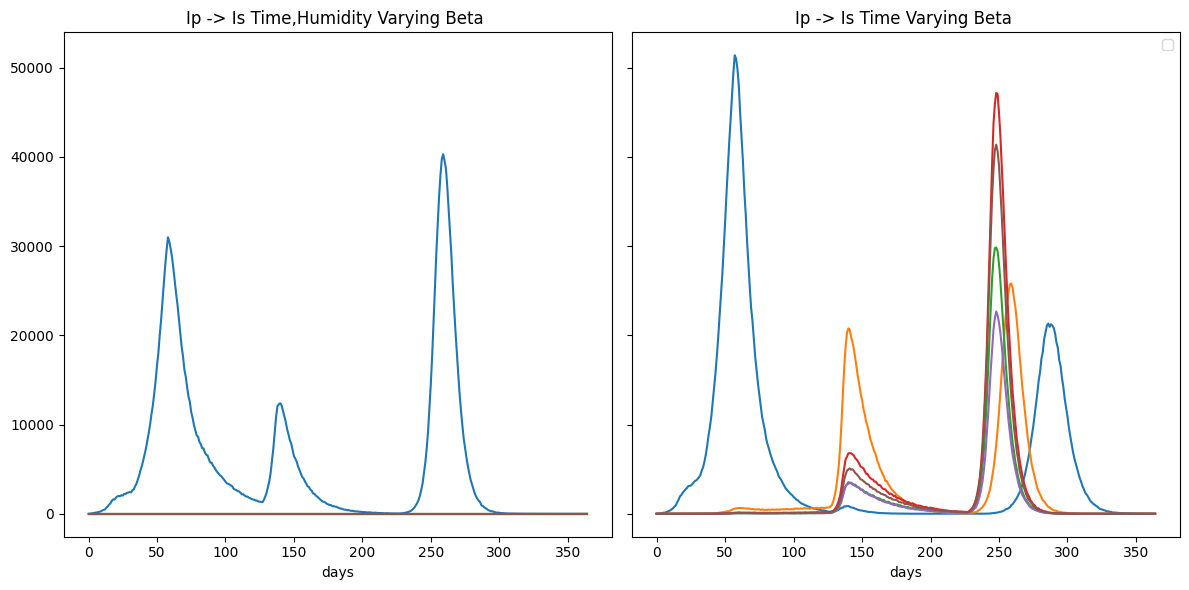

In [2]:
from epymorph.geo.abstract import proxy as G

sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['sparsemod'](),
    mvm_builder=mm_library['centroids']())

def calculate_beta(t,n):
    geo_humidity = G['humidity'][t, n]

    if 0 <= t < 15:
        beta = 0.7
    elif 15 <= t < 30:
        beta = 0.2
    elif 30 <= t < 55:
        beta = 0.4
    elif 55 <= t < 75:
        beta = 0.1
    elif 75 <= t < 125:
        beta = 0.15
    elif 125 <= t < 135:
        beta = 1.2
    elif 135 <= t < 225:
        beta = 0.1
    else:
        beta = 1.5

    humidity_factor = (max(0.003404, min(geo_humidity, 0.02008)) - 0.003404) / (0.02008 - 0.003404) # type: ignore
    beta *= 0.5 + humidity_factor 

    return beta


param = {
    'move_control': 1,
    'theta': 0.1,
    'omega': [0.55,0.05],
    'delta': [0.333, 0.5, 0.166,0.142,0.125],
    'gamma': [0.166, 0.333, 0.25],
    'rho': [0.4, 0.175, 0.015, 0.2, 0.6],
    'beta': calculate_beta ,
    'phi':0.1
}

out = sim.run(
    param=param,
    start_date=date(2015, 1, 1),
    duration_days=365,
    initializer=init,
    rng=np.random.default_rng(1)
)
plot_subplots(out, out1, label1="Prevalence in Florida with Time,Humidity Varying Beta  ", label2="Prevalence in Florida with Time varying Beta", pop1 = 0,pop2=0, figsize=(24, 12))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out, 1))
ax2.plot(x_axis, event_y_axis(out1, 1))

ax1.set(title='S->E Time,Humidity Varying Beta ', xlabel='days')
ax2.set(title='S->E Time Varying Beta ', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out, 4))
ax2.plot(x_axis, event_y_axis(out1, 4))

ax1.set(title='Ip -> Is Time,Humidity Varying Beta ', xlabel='days')
ax2.set(title='Ip -> Is Time Varying Beta ', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()


## The Humidity value Plotted Over Time

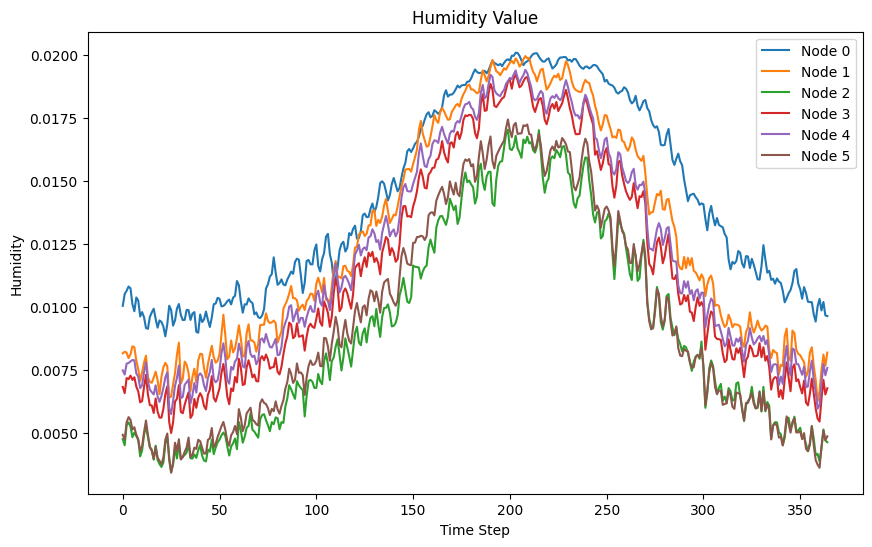

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data = out.ctx.geo['humidity']

num_nodes = data.shape[1]

plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(data[:, i], label=f'Node {i}')

plt.xlabel('Time Step')
plt.ylabel('Humidity')
plt.title('Humidity Value')
plt.legend()
plt.show()


## The Beta Parameter Plotted over Time

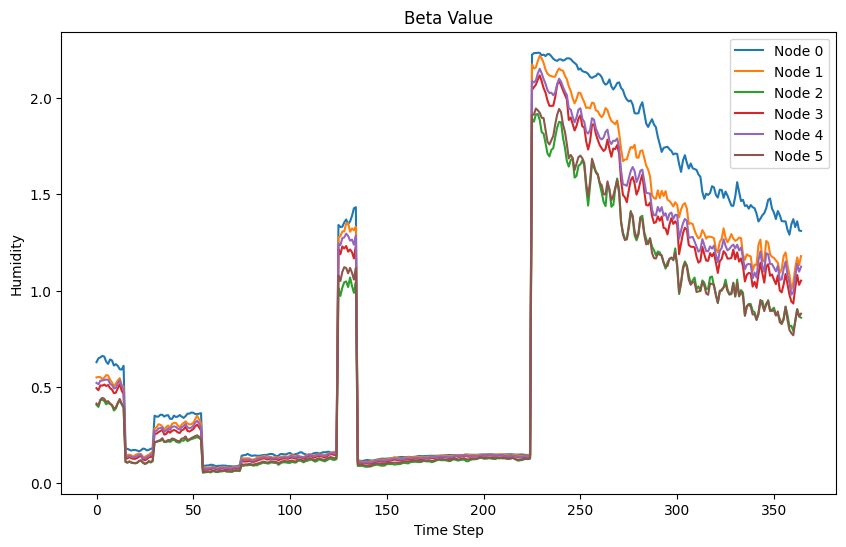

In [4]:
data = out.ctx.param['beta']

num_nodes = data.shape[1]

plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(data[:, i], label=f'Node {i}')

plt.xlabel('Time Step')
plt.ylabel('Humidity')
plt.title('Beta Value')
plt.legend()
plt.show()
